In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
beijing_df = pd.read_csv("Beijing_labeled.csv")
shenyang_df = pd.read_csv("Shenyang_labeled.csv")
guangzho_df = pd.read_csv("Guangzhou_labeled.csv")
shanghai_df = pd.read_csv("Shanghai_labeled.csv")

data_train = pd.concat([beijing_df, shenyang_df], ignore_index=True)
print(f"Entries in training data: {data_train.shape[0]}")
print(data_train['PM_HIGH'].value_counts(normalize=True) * 100)

data_test = pd.concat([guangzho_df, shanghai_df], ignore_index=True)
print(f"Entries in test data: {data_test.shape[0]}")
print(data_test['PM_HIGH'].value_counts(normalize=True) * 100)

Entries in training data: 2895
PM_HIGH
0.0    72.504318
1.0    27.495682
Name: proportion, dtype: float64
Entries in test data: 2703
PM_HIGH
0.0    91.897891
1.0     8.102109
Name: proportion, dtype: float64


In [3]:
class MajorityClassifier:
    def __init__(self, clusters):
        self.model = KMeans(n_clusters=clusters, random_state=13)
        self.k_clusters = clusters
        self.centroid_labels = {}

    def fit(self, X_data, y_data):
        self.model.fit(X_data)
        self._assign_centroid_majority(y_data)

    def _assign_centroid_majority(self, y_data):
        label_list = self.model.labels_ 

        for cluster in range(self.k_clusters):
            points_in_cluster = []

            for i in range(len(label_list)):
                if label_list[i] == cluster:
                    points_in_cluster.append(y_data[i])
            
            counter = {}

            for point in points_in_cluster:
                if point not in counter:
                    counter[point] = 1  
                else:
                    counter[point] += 1  

            self.centroid_labels[cluster] = int(max(counter, key=counter.get))

    def predict(self, X):
        cluster_assignments = self.model.predict(X)
        predictions = []
        
        for cluster in cluster_assignments:
            predictions.append(int(self.centroid_labels[cluster]))
        
        return np.array(predictions)

    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = accuracy_score(y, y_pred)
        return accuracy

In [9]:
X_train = data_train.drop(columns=['PM_HIGH'])
y_train = data_train['PM_HIGH'].astype(int)

X_test = data_test.drop(columns=['PM_HIGH'])
y_test = data_test['PM_HIGH'].astype(int)


numerical_features = ["DEWP", "HUMI", "PRES", "TEMP", "Iws", "precipitation"]
categorical_features = ["season", "cbwd_NE", "cbwd_NW", "cbwd_SE"]

# we only want to scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_features])
X_test_scaled = scaler.transform(X_test[numerical_features])

X_train_final = np.column_stack([X_train_scaled, X_train[categorical_features].values])
X_test_final = np.column_stack([X_test_scaled, X_test[categorical_features].values])


In [14]:
X_train_final, X_val_final, y_train, y_val = train_test_split(X_train_final, y_train, test_size=0.2, random_state=13)
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [22]:
n_clusters = np.arange(1,30,1)

train_precision = []
train_accuracy = []
train_recall = []
train_f1 = []

val_precision = []
val_accuracy = []
val_recall = []
val_f1 = []

test_precision = []
test_accuracy = []
test_recall = []
test_f1 = []

for k in n_clusters:
    classifier = MajorityClassifier(clusters=k)
    classifier.fit(X_train_final.copy(), y_train.copy())

    # training
    y_pred_train = classifier.predict(X_train_final.copy())
    train_accuracy.append(classifier.score(X_train_final.copy(), y_train.copy()))
    train_precision.append(precision_score(y_train.copy(), y_pred_train, average='binary', zero_division=0))
    train_recall.append(recall_score(y_train.copy(), y_pred_train, average='binary'))
    train_f1.append(f1_score(y_train.copy(), y_pred_train, average='binary'))

    # validation
    y_pred_val = classifier.predict(X_val_final.copy())
    val_accuracy.append(classifier.score(X_val_final.copy(), y_val.copy()))
    val_precision.append(precision_score(y_val.copy(), y_pred_val, average='binary', zero_division=0))
    val_recall.append(recall_score(y_val.copy(), y_pred_val, average='binary'))
    val_f1.append(f1_score(y_val.copy(), y_pred_val, average='binary'))

    # tests
    y_pred_test = classifier.predict(X_test_final.copy())
    test_accuracy.append(classifier.score(X_test_final.copy(), y_test.copy()))
    test_precision.append(precision_score(y_test.copy(), y_pred_test, average='binary', zero_division=0))
    test_recall.append(recall_score(y_test.copy(), y_pred_test, average='binary'))
    test_f1.append(f1_score(y_test.copy(), y_pred_test, average='binary'))

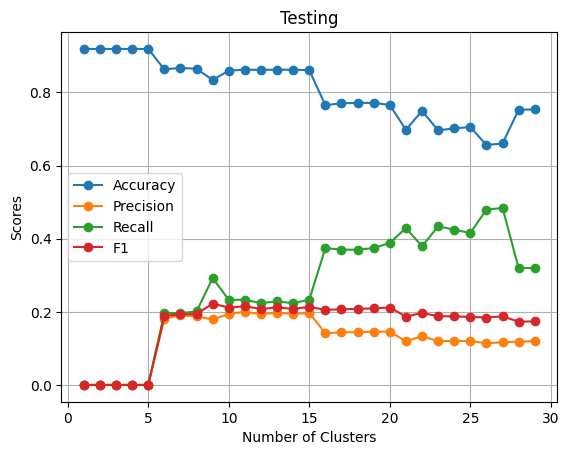

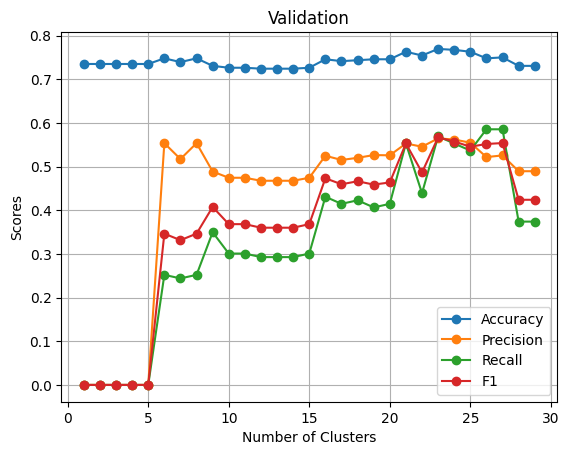

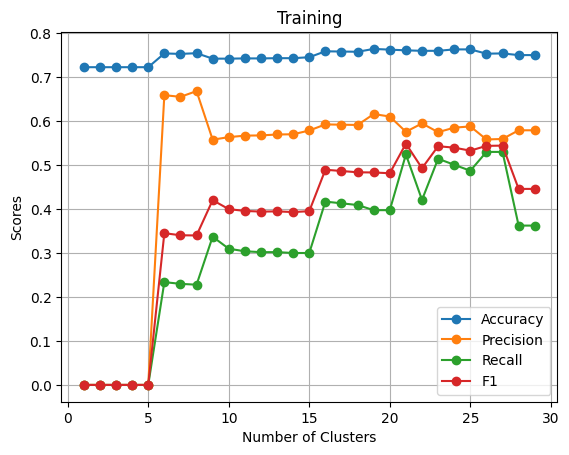

In [23]:
def plot(accuracy_, precision_, recall_, f1_, title_):

    plt.plot(n_clusters, accuracy_, label="Accuracy", marker="o")
    plt.plot(n_clusters, precision_, label="Precision", marker="o")
    plt.plot(n_clusters, recall_, label="Recall", marker="o")
    plt.plot(n_clusters, f1_, label="F1", marker="o")

    plt.xlabel("Number of Clusters")
    plt.ylabel("Scores")
    plt.title(title_)
    plt.legend()
    plt.grid(True)
    plt.show()

plot(test_accuracy, test_precision, test_recall, test_f1, "Testing")
plot(val_accuracy, val_precision, val_recall, val_f1, "Validation")
plot(train_accuracy, train_precision, train_recall, train_f1, "Training")

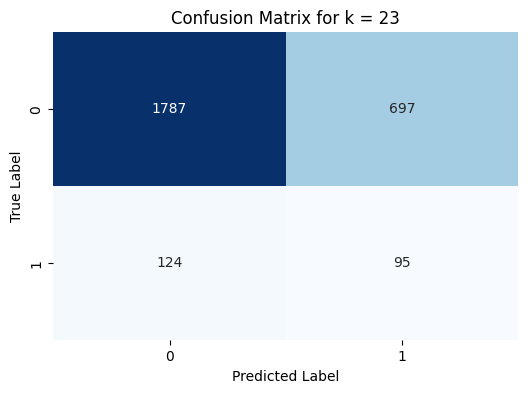

In [21]:
chosen_k = 23
classifier = MajorityClassifier(clusters=chosen_k)
classifier.fit(X_train_final.copy(), y_train.copy())

y_pred_test = classifier.predict(X_test_final.copy())
cm = confusion_matrix(y_test.copy(), y_pred_test)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix for k = {chosen_k}")
plt.show()